In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from pathlib import Path
folder_path = Path('verification_data') / '131_2_4_20_60_5'
common_props_path = 'commonProps.csv'
common_props_raw: pd.DataFrame = pd.read_csv(folder_path / common_props_path)
common_props_raw

,runNumber,timePoint,diskLoad,ioChannelLoad,processorsLoad,totalWaitAllocate,useOfPage
0,0,0.000000,0.000000,0.000000,0.000000,0.0,0.0
1,0,2.265625,0.000000,0.000000,0.000000,0.0,0.0
2,0,5.000000,0.000000,0.000000,0.000000,0.0,0.0
3,0,5.000000,0.000000,0.000000,0.000000,0.0,33.0
4,0,5.000000,0.000000,0.000000,0.873322,0.0,33.0
...,...,...,...,...,...,...,...
7582951,4,799994.236190,0.001557,0.002493,0.831157,26954.0,128.0
7582952,4,799994.236190,0.001557,0.002493,0.831162,26954.0,95.0
7582953,4,799994.254380,0.001557,0.002493,0.831162,26954.0,95.0
7582954,4,799994.272088,0.001557,0.002493,0.831162,26954.0,95.0


In [3]:
common_props_raw.dtypes

runNumber              int64
timePoint            float64
diskLoad             float64
ioChannelLoad        float64
processorsLoad       float64
totalWaitAllocate    float64
useOfPage            float64
dtype: object

In [4]:
time_in_system_file_path = 'timeInSystem.csv'
time_in_system_raw: pd.DataFrame = pd.read_csv(folder_path / time_in_system_file_path)
time_in_system_raw

,runNumber,timePoint,timeInSystem
0,0,13.766207,8.766207
1,0,20.190868,11.190868
2,0,27.688075,10.688075
3,0,47.292850,24.292850
4,0,52.221386,39.221386
...,...,...,...
665654,4,799967.870962,18.870962
665655,4,799972.408201,18.408201
665656,4,799978.204211,15.204211
665657,4,799986.543617,72.543617


In [5]:
time_in_system_raw.dtypes

runNumber         int64
timePoint       float64
timeInSystem    float64
dtype: object

In [6]:
time_wait_allocate_file_path = 'timeWaitAllocate.csv'
time_wait_allocate_raw: pd.DataFrame = pd.read_csv(folder_path / time_wait_allocate_file_path, header=0)
time_wait_allocate_raw

,runNumber,timePoint,timeWaitAllocate
0,0,13.733221,0.733221
1,0,20.132841,3.132841
2,0,27.632820,4.632820
3,0,47.244099,8.244099
4,0,52.172628,1.172628
...,...,...,...
551733,4,799959.029344,5.029344
551734,4,799964.361750,1.361750
551735,4,799967.813636,53.813636
551736,4,799972.369404,4.369404


In [7]:
time_wait_allocate_raw.dtypes

runNumber             int64
timePoint           float64
timeWaitAllocate    float64
dtype: object

In [8]:
import numpy as np
from array import array
from typing import Sequence

def calculate_means_through_time(
    time_points: pd.Series,
    values: pd.Series
) -> array[float]:
    prev_time_point = time_points.iloc[0]
    delay_sum = 0.0
    value_sum = 0.0

    values_through_time = array('d')

    for time_point, value in zip(time_points.iloc[1:], values):
        delay = time_point - prev_time_point
        prev_time_point = time_point
        delay_sum += delay
        value_sum += value * delay
        values_through_time.append(value_sum / delay_sum)

    return values_through_time

def calculate_stddevs_through_time(
    time_points: pd.Series,
    values: pd.Series,
    means: array[float]
) -> array[float]:
    prev_time_point = time_points.iloc[0]
    delay_sum = 0.0
    value_sum = 0.0

    stddevs_through_time: array[float] = array('d')

    for time_point, value, mean in zip(time_points.iloc[1:], values, means):
        delay = time_point - prev_time_point
        prev_time_point = time_point
        delay_sum += delay
        value_sum += ((value - mean) ** 2) * delay
        stddevs_through_time.append(np.sqrt(value_sum / delay_sum))

    return stddevs_through_time


def calculate_mean(time_points: pd.Series, values: pd.Series) -> float:
    prev_time_point = time_points.iloc[0]
    delay_sum = 0.0
    value_sum = 0.0

    for time_point, value in zip(time_points.iloc[1:], values):
        delay = time_point - prev_time_point
        prev_time_point = time_point
        delay_sum += delay
        value_sum += value * delay

    return value_sum / delay_sum

def calculate_std_dev(time_points: pd.Series, values: pd.Series, mean: float) -> float:
    prev_time_point = time_points.iloc[0]
    delay_sum = 0.0
    value_sum = 0.0

    for time_point, value in zip(time_points.iloc[1:], values):
        delay = time_point - prev_time_point
        prev_time_point = time_point
        delay_sum += delay
        value_sum += ((value - mean) ** 2) * delay

    return np.sqrt(value_sum / delay_sum)

In [9]:
import attr

@attr.frozen
class PropertyMeanStdDev:
    mean: array[float]
    stdDev: array[float]

def calc_mean_stddev_through_time(time_points: pd.Series, props: pd.Series) -> PropertyMeanStdDev:
    means = calculate_means_through_time(time_points, props)
    return PropertyMeanStdDev(
        means,
        calculate_stddevs_through_time(time_points, props, means)
    )

In [10]:
from collections import deque

time_points_mat: deque[Sequence[float]] = deque()
disk_load_mean_stddev_mat: deque[PropertyMeanStdDev] = deque()
io_channel_load_mean_stddev_mat: deque[PropertyMeanStdDev] = deque()
processors_load_mean_stddev_mat: deque[PropertyMeanStdDev] = deque()
use_of_page_mean_stddev_mat: deque[PropertyMeanStdDev] = deque()
total_wait_allocate_stddev_mat: deque[PropertyMeanStdDev] = deque()

time_in_system_mean_stddev_mat: deque[PropertyMeanStdDev] = deque()
time_wait_allocate_mean_stddev_mat: deque[PropertyMeanStdDev] = deque()
time_in_system_time_points_mat: deque[PropertyMeanStdDev] = deque()
time_wait_allocate_time_points_mat: deque[PropertyMeanStdDev] = deque()

In [11]:
total_runs_num = len(common_props_raw['runNumber'].value_counts())
total_runs_num

5

In [12]:
for run_number in range(total_runs_num):
    common_props_raw_indexed = common_props_raw[common_props_raw['runNumber'] == run_number]
    time_points = common_props_raw_indexed['timePoint'][:-1]
    disk_load_mean_stddev_mat.append(calc_mean_stddev_through_time(time_points, common_props_raw_indexed['diskLoad']))
    io_channel_load_mean_stddev_mat.append(calc_mean_stddev_through_time(time_points, common_props_raw_indexed['ioChannelLoad']))
    processors_load_mean_stddev_mat.append(calc_mean_stddev_through_time(time_points, common_props_raw_indexed['processorsLoad']))
    use_of_page_mean_stddev_mat.append(calc_mean_stddev_through_time(time_points, common_props_raw_indexed['useOfPage']))
    total_wait_allocate_stddev_mat.append(calc_mean_stddev_through_time(time_points, common_props_raw_indexed['totalWaitAllocate']))
    time_points_mat.append(time_points[:-1])

    time_in_system_raw_indexed = time_in_system_raw[time_in_system_raw['runNumber'] == run_number]
    time_in_system_time_points = time_in_system_raw_indexed['timePoint']
    time_in_system_mean_stddev_mat.append(calc_mean_stddev_through_time(time_in_system_time_points, time_in_system_raw_indexed['timeInSystem']))
    time_in_system_time_points_mat.append(time_in_system_time_points.iloc[:-1])

    time_wait_allocate_raw_indexed = time_wait_allocate_raw[time_wait_allocate_raw['runNumber'] == run_number]
    time_wait_allocate_time_points = time_wait_allocate_raw_indexed['timePoint']
    time_wait_allocate_mean_stddev_mat.append(calc_mean_stddev_through_time(time_wait_allocate_time_points, time_wait_allocate_raw_indexed['timeWaitAllocate']))
    time_wait_allocate_time_points_mat.append(time_wait_allocate_time_points.iloc[:-1])

In [13]:
from typing import Iterable

def plot_matrix(time_points_mat: Iterable[float], value_mat: Iterable[float], ylabel: str):
    for run_num, row in enumerate(zip(time_points_mat, value_mat)):
        time_points_row = row[0]
        value_row = row[1]
        plt.plot(time_points_row, value_row, label=f'Run {run_num}')

    plt.title(f'{ylabel} vs. TimePoint for Each Run')
    plt.xlabel('TimePoint')
    plt.ylabel(ylabel)
    plt.legend(title='Run Number')
    plt.grid(True)
    plt.savefig(fname=f'{ylabel}.svg', format='svg')
    plt.show()

def plot_matrix_mean_std_dev(time_points_mat: Sequence[float], value_mat: deque[PropertyMeanStdDev], ylabel: str):
    plot_matrix(time_points_mat, (v.mean for v in value_mat), ylabel + 'Mean')
    plot_matrix(time_points_mat, (v.stdDev for v in value_mat), ylabel + 'StdDev')

/tmp/ipykernel_5386/3265177816.py:14: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(fname=f'{ylabel}.svg', format='svg')
/home/sideshowbobgot/miniconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


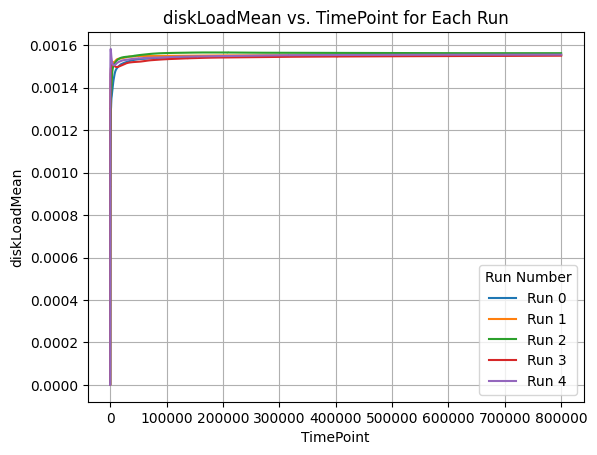

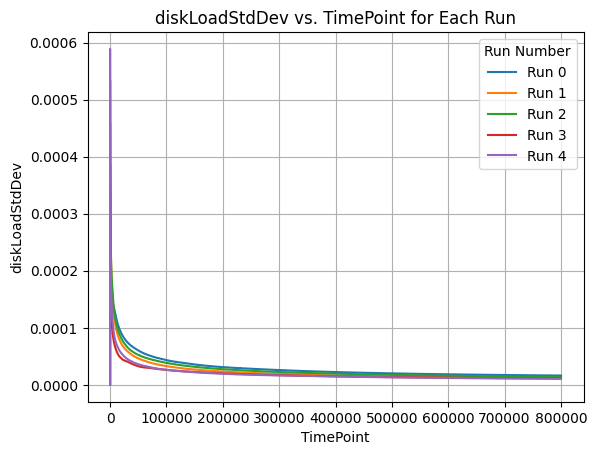

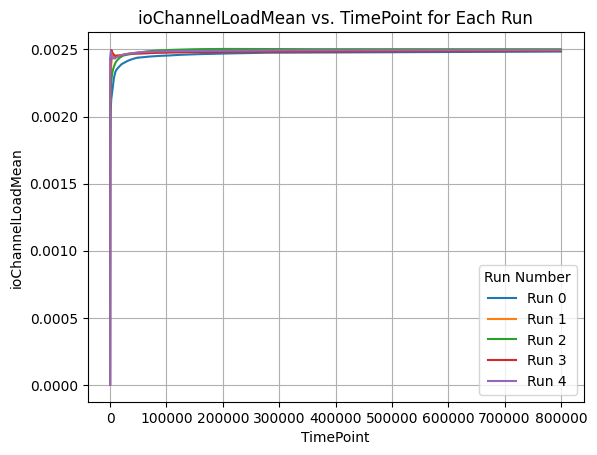

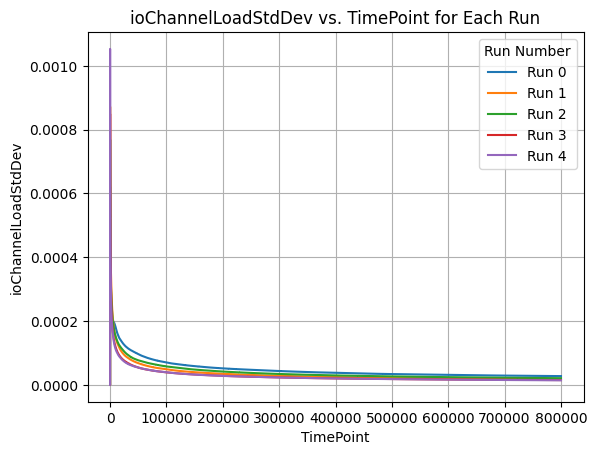

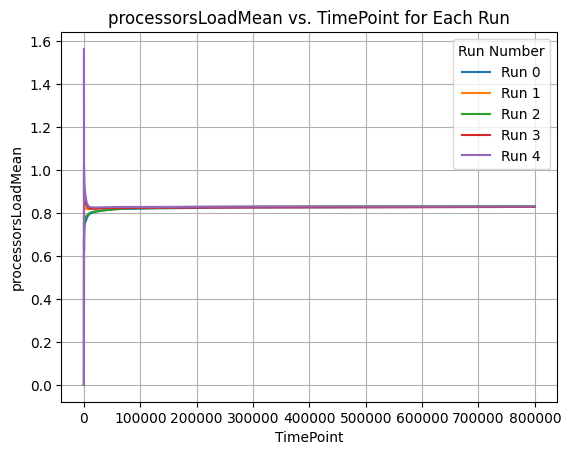

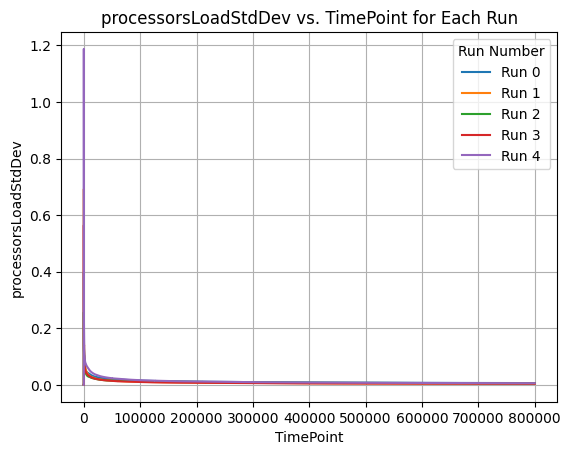

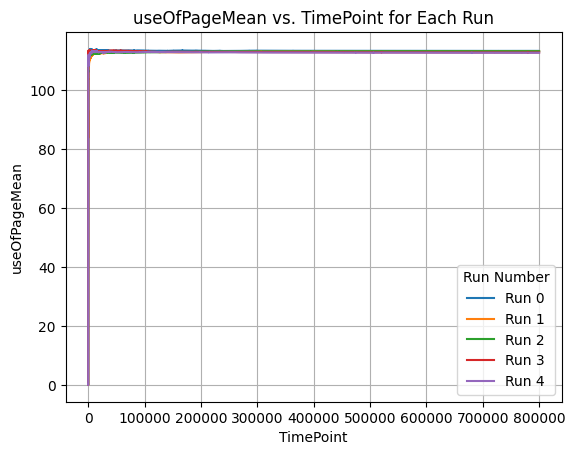

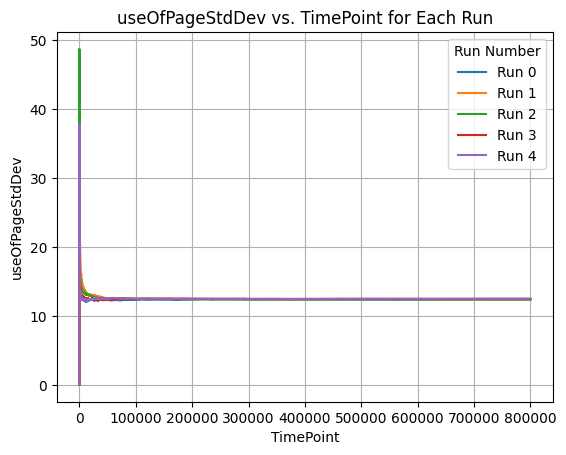

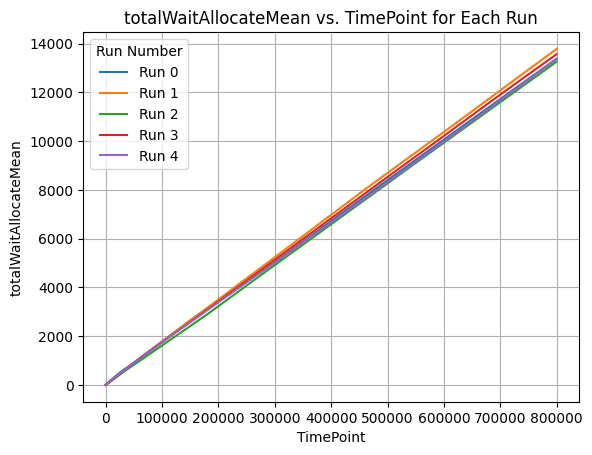

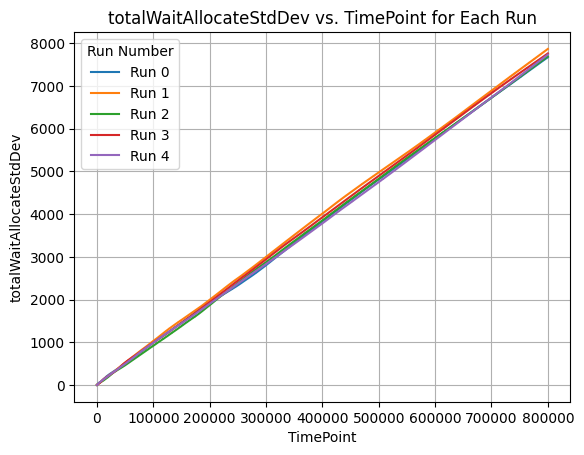

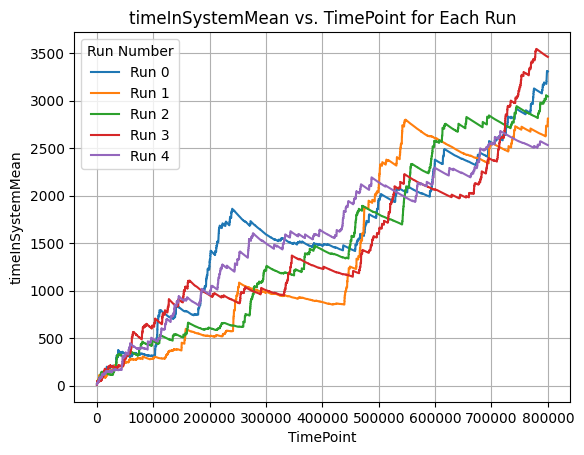

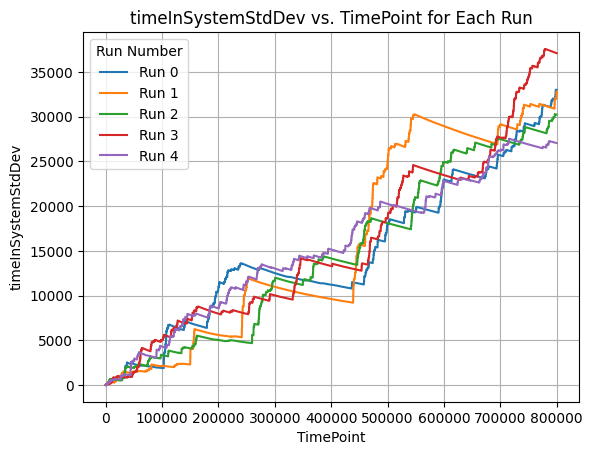

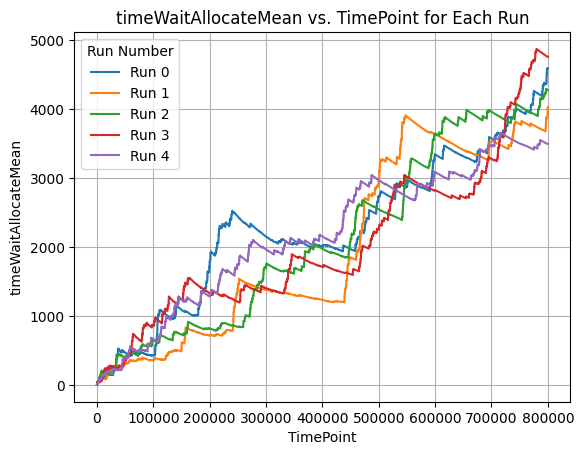

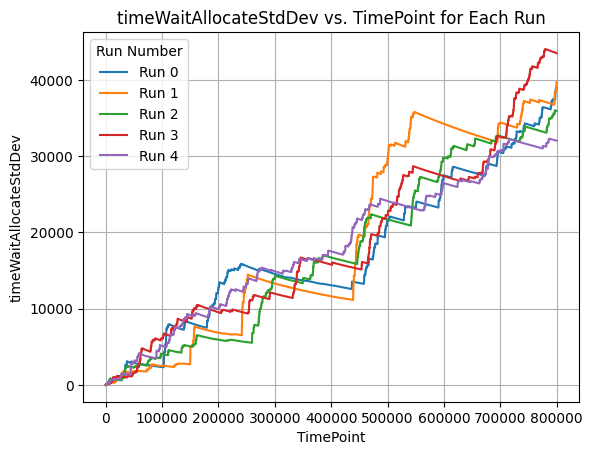

In [14]:
plot_matrix_mean_std_dev(time_points_mat, disk_load_mean_stddev_mat, 'diskLoad')
plot_matrix_mean_std_dev(time_points_mat, io_channel_load_mean_stddev_mat, 'ioChannelLoad')
plot_matrix_mean_std_dev(time_points_mat, processors_load_mean_stddev_mat, 'processorsLoad')
plot_matrix_mean_std_dev(time_points_mat, use_of_page_mean_stddev_mat, 'useOfPage')
plot_matrix_mean_std_dev(time_points_mat, total_wait_allocate_stddev_mat, 'totalWaitAllocate')
plot_matrix_mean_std_dev(time_in_system_time_points_mat, time_in_system_mean_stddev_mat, 'timeInSystem')
plot_matrix_mean_std_dev(time_wait_allocate_time_points_mat, time_wait_allocate_mean_stddev_mat, 'timeWaitAllocate')


In [15]:
transit_period_start_at = 600000

In [16]:
common_props_stable = common_props_raw[common_props_raw['timePoint'] > transit_period_start_at]
time_in_system_stable = time_in_system_raw[time_in_system_raw['timePoint'] > transit_period_start_at]
time_wait_allocate_stable = time_wait_allocate_raw[time_wait_allocate_raw['timePoint'] > transit_period_start_at]

common_props_stable = common_props_raw[(common_props_raw['timePoint'] > transit_period_start_at) & (common_props_raw['runNumber'] == 0)]
time_in_system_stable = time_in_system_raw[(time_in_system_raw['timePoint'] > transit_period_start_at) & (time_in_system_raw['runNumber'] == 0)]
time_wait_allocate_stable = time_wait_allocate_raw[(time_wait_allocate_raw['timePoint'] > transit_period_start_at) & (time_wait_allocate_raw['runNumber'] == 0)]

In [17]:
def show_hist(data, col_name: str) -> None:
    plt.figure(figsize=(10, 6))
    plt.hist(data[col_name], bins=100, edgecolor='k', alpha=0.7)
    plt.title(f'Histogram of {col_name}')
    plt.xlabel(col_name)
    plt.ylabel('Frequency')
    plt.grid(True)

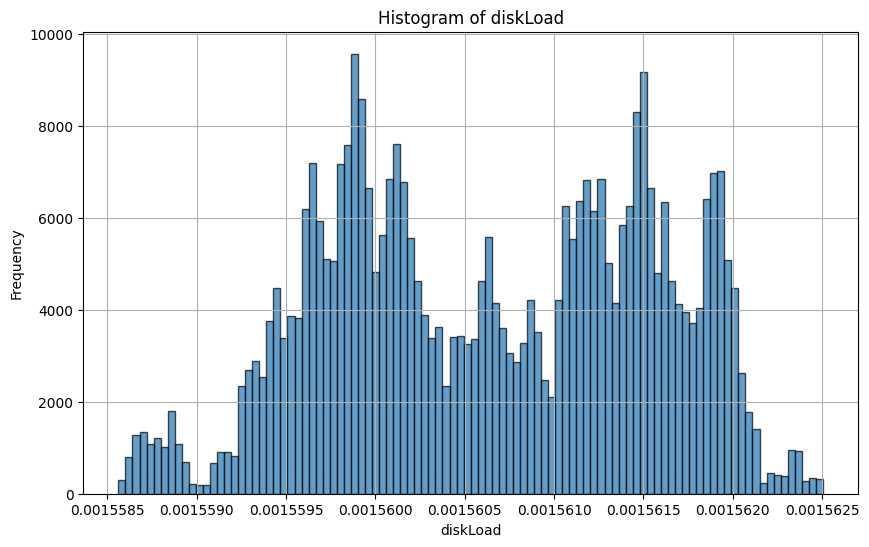

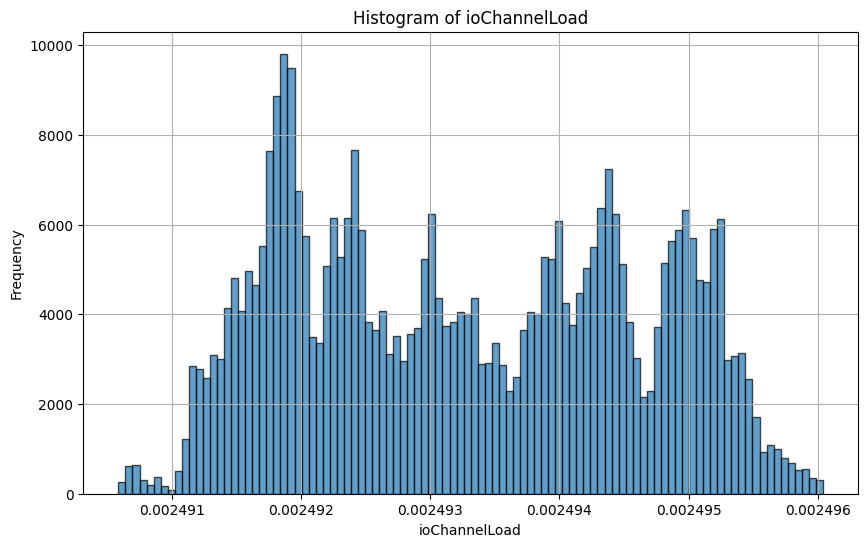

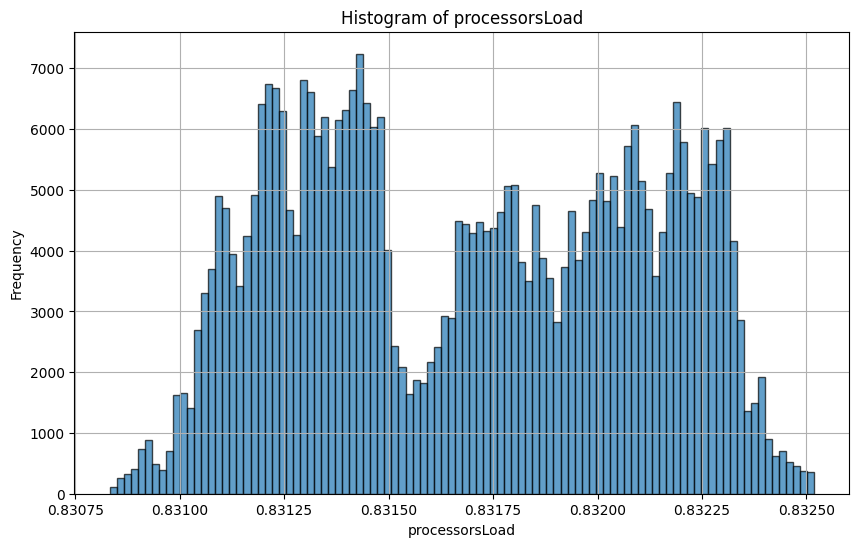

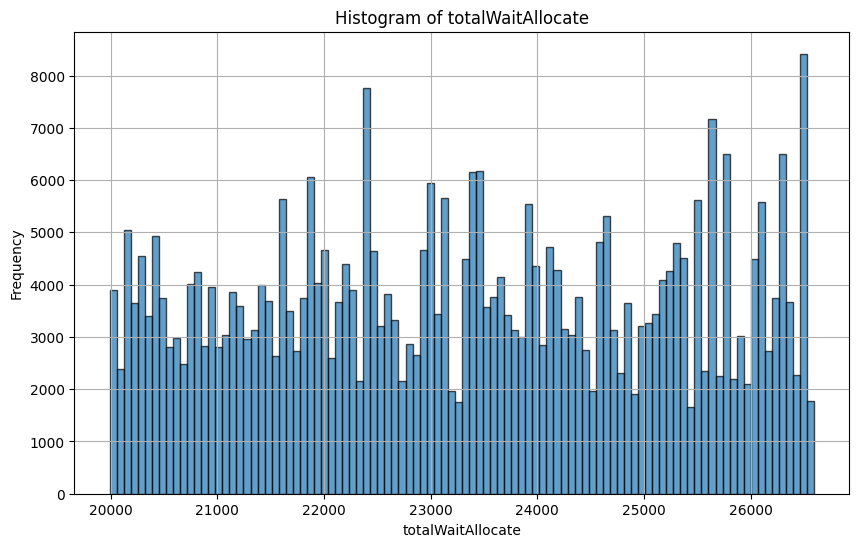

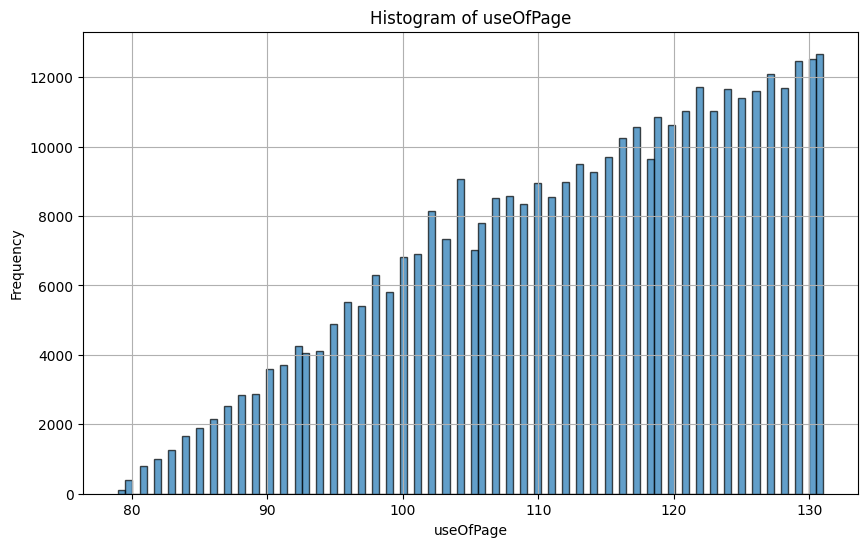

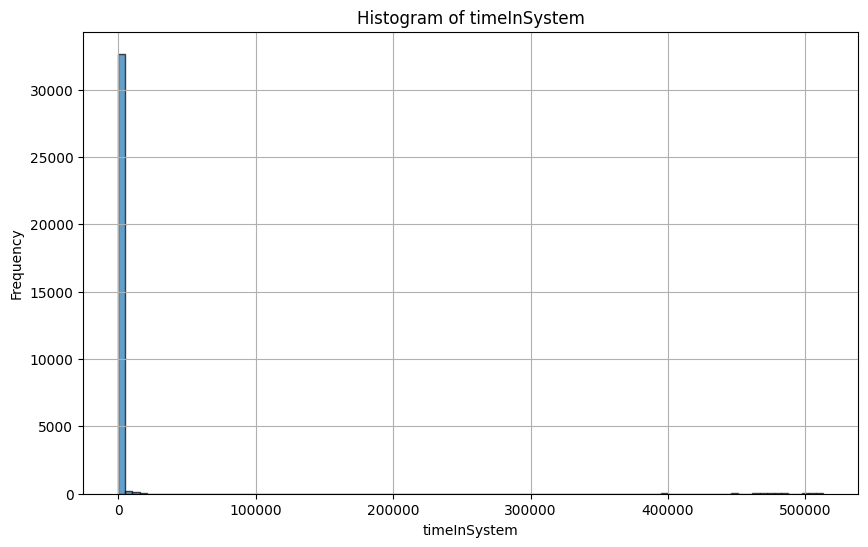

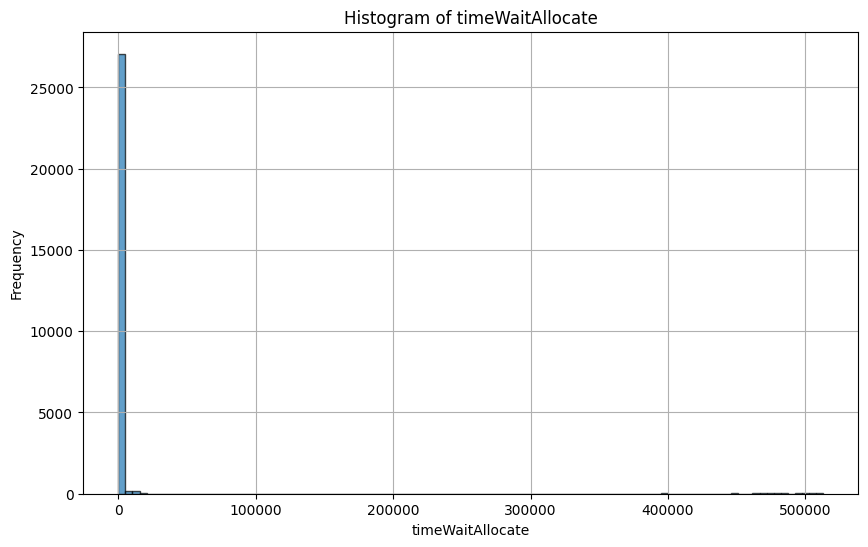

In [18]:
show_hist(common_props_stable, 'diskLoad')
show_hist(common_props_stable, 'ioChannelLoad')
show_hist(common_props_stable, 'processorsLoad')
show_hist(common_props_stable, 'totalWaitAllocate')
show_hist(common_props_stable, 'useOfPage')
show_hist(time_in_system_stable, 'timeInSystem')
show_hist(time_wait_allocate_stable, 'timeWaitAllocate')

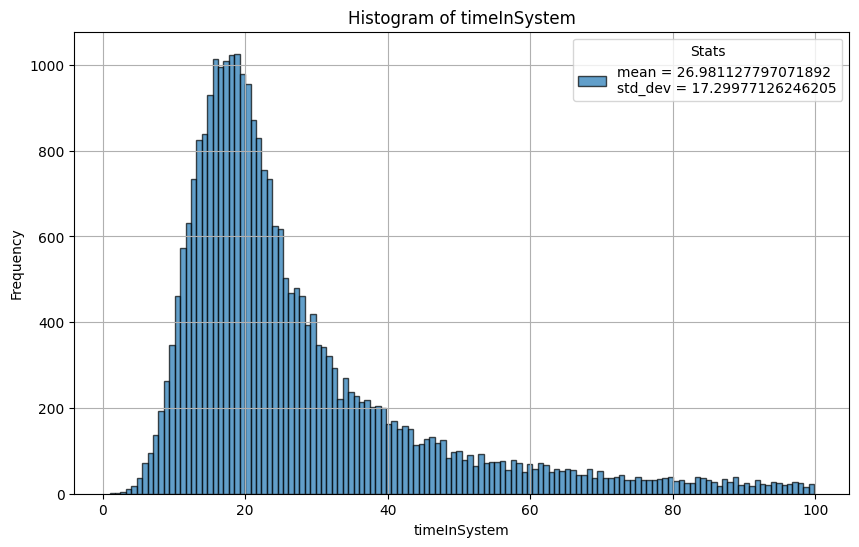

In [19]:
time_in_system_stable_filtered = time_in_system_stable[time_in_system_stable['timeInSystem'] < 100]
time_in_system_stable_filtered_mean = calculate_mean(
    time_in_system_stable_filtered['timePoint'],
    time_in_system_stable_filtered['timeInSystem']
)
time_in_system_stable_filtered_std_dev = calculate_std_dev(
    time_in_system_stable_filtered['timePoint'],
    time_in_system_stable_filtered['timeInSystem'],
    time_in_system_stable_filtered_mean
)

plt.figure(figsize=(10, 6))
plt.hist(
    time_in_system_stable_filtered['timeInSystem'],
    bins=130,
    edgecolor='k',
    alpha=0.7,
    label=f'mean = {time_in_system_stable_filtered_mean}\nstd_dev = {time_in_system_stable_filtered_std_dev}'
)
plt.title(f'Histogram of timeInSystem')
plt.xlabel('timeInSystem')
plt.ylabel('Frequency')
plt.legend(title='Stats')
plt.grid(True)

In [20]:
from typing import Sequence
import numpy as np
from scipy.stats import chi2

def chi_squared_normality_test(data: Sequence[float], mean: float, std_dev: float) -> bool:
    # Calculate the number of bins using Sturges' rule
    num_bins = int(np.ceil(1 + 3.322 * np.log10(len(data))))
    
    # Create the histogram of the data
    observed_counts, bin_edges = np.histogram(data, bins=num_bins)
    
    # Calculate expected frequencies for a normal distribution
    expected_counts = []
    for i in range(len(bin_edges) - 1):
        # Calculate the cumulative probability for the bin range
        bin_prob = (
            (1 / (std_dev * np.sqrt(2 * np.pi))) *
            (np.exp(-0.5 * ((bin_edges[i + 1] - mean) / std_dev) ** 2) - 
             np.exp(-0.5 * ((bin_edges[i] - mean) / std_dev) ** 2))
        )
        expected_counts.append(bin_prob * len(data))
    
    # Perform chi-squared statistic
    expected_counts = np.array(expected_counts)
    chi_squared_stat = np.sum((observed_counts - expected_counts) ** 2 / expected_counts)
    
    # Degrees of freedom = (number of bins - 1 - number of estimated parameters)
    degrees_of_freedom = num_bins - 1 - 2
    
    # Find the critical value for the chi-squared distribution
    critical_value = chi2.ppf(0.95, degrees_of_freedom)
    
    # Check if the chi-squared statistic is within the critical range
    return chi_squared_stat < critical_value

In [21]:
time_in_system_stable_filtered_is_normal = chi_squared_normality_test(
    time_in_system_stable_filtered['timeInSystem'],
    time_in_system_stable_filtered_mean,
    time_in_system_stable_filtered_std_dev
)
time_in_system_stable_filtered_is_normal

False

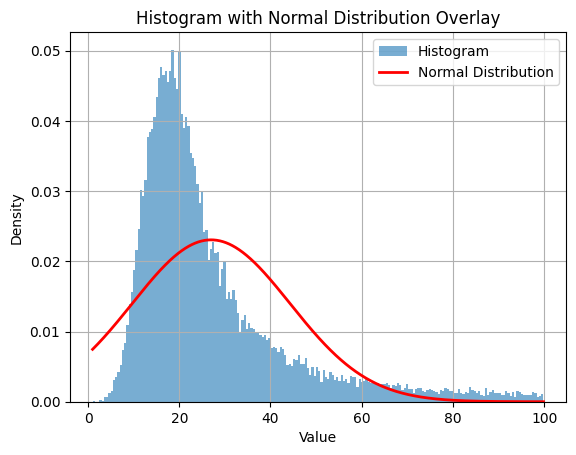

In [22]:
from scipy.stats import norm

count, bins, _ = plt.hist(time_in_system_stable_filtered['timeInSystem'], bins=200, density=True, alpha=0.6, label='Histogram')
x = np.linspace(bins[0], bins[-1], 1000)
pdf = norm.pdf(
    x,
    time_in_system_stable_filtered_mean,
    time_in_system_stable_filtered_std_dev
)
plt.plot(x, pdf, 'r-', lw=2, label='Normal Distribution')
plt.title('Histogram with Normal Distribution Overlay')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

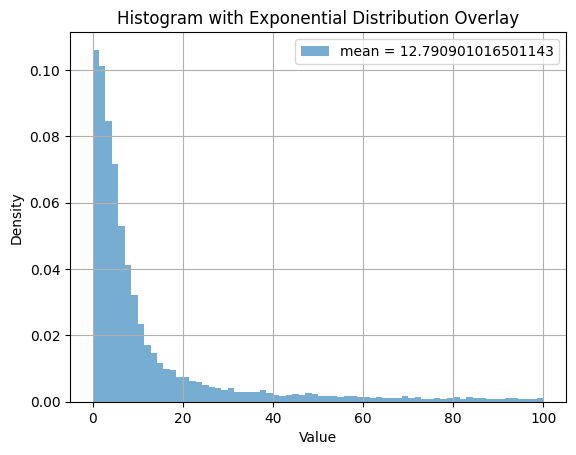

In [23]:
from scipy.stats import expon

time_wait_allocate_stable_filtered = time_wait_allocate_stable[time_wait_allocate_stable['timeWaitAllocate'] < 12]
time_wait_allocate_stable_filtered = time_wait_allocate_stable[time_wait_allocate_stable['timeWaitAllocate'] < 100]

time_wait_allocate_stable_filtered_mean = calculate_mean(
    time_wait_allocate_stable_filtered['timePoint'],
    time_wait_allocate_stable_filtered['timeWaitAllocate']
)
time_wait_allocate_stable_filtered_std_dev = calculate_std_dev(
    time_wait_allocate_stable_filtered['timePoint'],
    time_wait_allocate_stable_filtered['timeWaitAllocate'],
    time_wait_allocate_stable_filtered_mean
)

count, bins, _ = plt.hist(
    time_wait_allocate_stable_filtered['timeWaitAllocate'],
    bins=70,
    density=True,
    alpha=0.6,
    label=f'mean = {time_wait_allocate_stable_filtered_mean}'
)
plt.title('Histogram with Exponential Distribution Overlay')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

In [24]:
def chi_squared_exponential_test(data: Sequence[float], mean: float, alpha: float = 0.05) -> bool:
    # Sort data and calculate the number of bins
    sorted_data = np.sort(data)
    n = len(data)
    bin_width = 2 / np.sqrt(n)  # Rule of thumb for bin width in exponential distribution
    bins = int(np.ceil(1 / bin_width))
    
    # Create bin edges and calculate expected frequencies
    max_data = max(sorted_data)
    bin_edges = np.linspace(0, max_data, bins + 1)
    observed_counts, _ = np.histogram(sorted_data, bins=bin_edges)
    
    # Calculate expected frequencies for exponential distribution
    expected_counts = np.diff(
        len(data) * (1 - np.exp(-bin_edges / mean))
    )
    
    # Calculate chi-squared statistic
    chi_squared_stat = np.sum((observed_counts - expected_counts)**2 / expected_counts)
    
    # Degrees of freedom
    degrees_of_freedom = bins - 1
    
    # Compute the p-value
    p_value = 1 - chi2.cdf(chi_squared_stat, df=degrees_of_freedom)
    
    return p_value < alpha

In [25]:
chi_squared_exponential_test(
    time_wait_allocate_stable_filtered['timeWaitAllocate'],
    time_wait_allocate_stable_filtered_mean,
    0.05
)

True

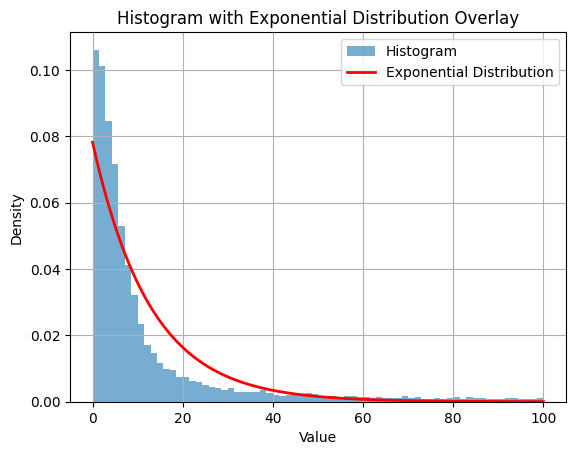

In [26]:
count, bins, _ = plt.hist(time_wait_allocate_stable_filtered['timeWaitAllocate'], bins=70, density=True, alpha=0.6, label='Histogram')
x = np.linspace(bins[0], bins[-1], 1000)

pdf = expon.pdf(x, scale=time_wait_allocate_stable_filtered_mean)
plt.plot(x, pdf, 'r-', lw=2, label='Exponential Distribution')
plt.title('Histogram with Exponential Distribution Overlay')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()